# RFM analysis

RFM analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM stands for Recency, Frequency, and Monetary Value.

- Recency: How recently a customer has made a purchase. The more recent the purchase, the higher the score.
- Frequency: How often a customer makes a purchase. The more frequent the purchase, the higher the score.
- Monetary Value: How much money a customer spends on purchases. The more money spent, the higher the score.
- RFM score: A score calculated by combining the three RFM values.
- RFM segment: A segment of customers with similar RFM scores.

In this notebook, I will use RFM analysis to segment the customers of our dataset into different groups.

There are many ways to calculate the RFM score. The number of groups may vary depending on the business needs, the size of the dataset, and the distribution of the RFM values. Similarly, the way to calculate the RFM score may vary depending on the business needs. And, finally, the segment labels may vary depending on the business needs.

One way to calculate the RFM score is to concatenate the three RFM values into a single string and then use the string as a key to group the customers. However, this is suitable only for big datasets. Because, considering a scale of 1 to 5 for each RFM value, the number of possible combinations is 5^3 = 125. This is the number of combinations from 111 to 555. Beware that these are not numbers, but strings. Example: R=1, F=3, M=5 -> RFM = '135', a client with low recency, medium frequency, and high monetary value.

For small and medium datasets, it is better to calculate the RFM score as a number. This number can be calculated by summing the three RFM values. Considering a scale of 1 to 5 for each RFM value, the RFM score will be between 3 (1 + 1 + 1 = 3) and 15 (5 + 5 + 5 = 15). So, the number of possible RFM scores is 15 - 3 + 1 = 13. This is a much smaller number of possible RFM scores than the number of possible RFM combinations. This is the approach we are going to use in this notebook since our dataset is relatively small.

Irrespective of the way to calculate the RFM score, the RFM segment is calculated by dividing the RFM score into groups. Each group can be labeled with a name, such as "Champions", "Loyal Customers", "Potential Loyalists", "New Customers", "At Risk", "Can't Lose Them", "Hibernating", "Lost Customers", etc. The number of groups and the labels may vary depending on the business needs and the distribution of the RFM values. The labels try to describe the behavior of the customers in each group.

For instance, in this notebook, we are going to consider the following RFM score calculation:

- Each RFM value is divided into 5 equal groups, with a score of 1 to 5.
- The RFM score is calculated by the sum of the three RFM values.
- The RFM score is divided into 5 segments, that may have different marketing strategies, as follows:


**1. Dormant (Score: 3 - 5)**
   - **Behavior:** These customers have the lowest engagement. They haven't purchased recently, buy infrequently, and spend little.

**2. Occasional (Score: 6 - 7)**
   - **Behavior:** Customers in this group make occasional purchases but are not highly engaged. They may have made a few transactions but do not shop consistently.

**3. Engaged (Score: 8 - 10)**
   - **Behavior:** These customers have moderate engagement. They purchase somewhat frequently, and their spending is stable.

**4. Valuable (Score: 11 - 12)**
   - **Behavior:** These are high-value customers who purchase often and spend significantly. They have shown consistent engagement.

**5. Elite (Score: 13 - 15)**
   - **Behavior:** The most valuable customers. They buy frequently, spend a lot, and have remained engaged over time.

This segmentation allows for targeted marketing strategies to maximize customer retention and revenue growth.

## Segmenting the customers

Let's grab the data and import the necessary libraries to start the analysis.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from marketing_case.config import PROCESSED_DATA_FILE, PROCESSED_DATA_FILE_RFM
from marketing_case.plots import (
    plot_category_distribution_by_cluster,
    plot_cluster_distribution_by_category,
)

In [2]:
df = pd.read_parquet(PROCESSED_DATA_FILE, engine="fastparquet")

df.head()

,ID,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Response,MonthsSinceEnrolled,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,...,1,22,46-60,1617,1529,0,0,0,0,22
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,...,0,3,46-60,27,21,2,1,0,0,4
2,4141,Graduation,Partner,71613.0,26,426,49,127,111,21,...,0,10,46-60,776,734,0,0,0,0,20
3,6182,Graduation,Partner,26646.0,26,11,4,20,10,3,...,0,4,18-30,53,48,1,1,0,0,6
4,5324,PhD,Partner,58293.0,94,173,43,118,46,27,...,0,5,31-45,422,407,1,1,0,0,14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   2205 non-null   int16   
 1   Education            2205 non-null   category
 2   Marital_Status       2205 non-null   category
 3   Income               2205 non-null   float64 
 4   Recency              2205 non-null   int8    
 5   MntWines             2205 non-null   int16   
 6   MntFruits            2205 non-null   int16   
 7   MntMeatProducts      2205 non-null   int16   
 8   MntFishProducts      2205 non-null   int16   
 9   MntSweetProducts     2205 non-null   int16   
 10  MntGoldProds         2205 non-null   int16   
 11  NumWebPurchases      2205 non-null   int8    
 12  NumCatalogPurchases  2205 non-null   int8    
 13  NumStorePurchases    2205 non-null   int8    
 14  Complain             2205 non-null   category
 15  Response             

For the RFM analysis, we are going to use the following columns:

In [ ]:
df_rfm = pd.DataFrame()

df_rfm["ID"] = df["ID"]
df_rfm["Recency"] = df["Recency"]
df_rfm["Frequency"] = df["NumTotalPurchases"]
df_rfm["Monetary"] = df["MntTotal"]

df_rfm.head()

,ID,Recency,Frequency,Monetary
0,5524,58,22,1617
1,2174,38,4,27
2,4141,26,20,776
3,6182,26,6,53
4,5324,94,14,422


As described in the beginning of the notebook, we are going to calculate the RFM score as the sum of the three RFM values. Then, we are going to divide the RFM score into 5 segments:

In [5]:
divisions = 5

r_labels, f_labels, m_labels = (
    range(divisions, 0, -1),  # Recency, the more recent the higher the score
    range(1, divisions + 1),  # Frequency, the more frequent the higher the score
    range(1, divisions + 1),  # Monetary, the more money spent the higher the score
)

df_rfm["R"] = pd.qcut(df_rfm["Recency"], q=divisions, labels=r_labels).astype(int)
df_rfm["F"] = pd.qcut(df_rfm["Frequency"], q=divisions, labels=f_labels).astype(int)
df_rfm["M"] = pd.qcut(df_rfm["Monetary"], q=divisions, labels=m_labels).astype(int)

df_rfm["RFM"] = df_rfm["R"] + df_rfm["F"] + df_rfm["M"]

df_rfm["Segment"] = pd.cut(
    df_rfm["RFM"],
    [3, 6, 8, 11, 13, 16],
    right=False,
    labels=["Dormant", "Occasional", "Engaged", "Valuable", "Elite"],
)

df_rfm.head()

,ID,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,5524,58,22,1617,3,5,5,13,Elite
1,2174,38,4,27,4,1,1,6,Occasional
2,4141,26,20,776,4,4,4,12,Valuable
3,6182,26,6,53,4,2,1,7,Occasional
4,5324,94,14,422,1,3,3,7,Occasional


Now, we can check the distribution of the RFM score and the RFM segments.

In [6]:
df_rfm["RFM"].value_counts().sort_index()

RFM
3      78
4     105
5     179
6     193
7     233
8     193
9     230
10    219
11    279
12    180
13    163
14    129
15     24
Name: count, dtype: int64

In [ ]:
df_rfm["Segment"].value_counts().sort_index()

Segment
Dormant       362
Occasional    426
Engaged       642
Valuable      459
Elite         316
Name: count, dtype: int64

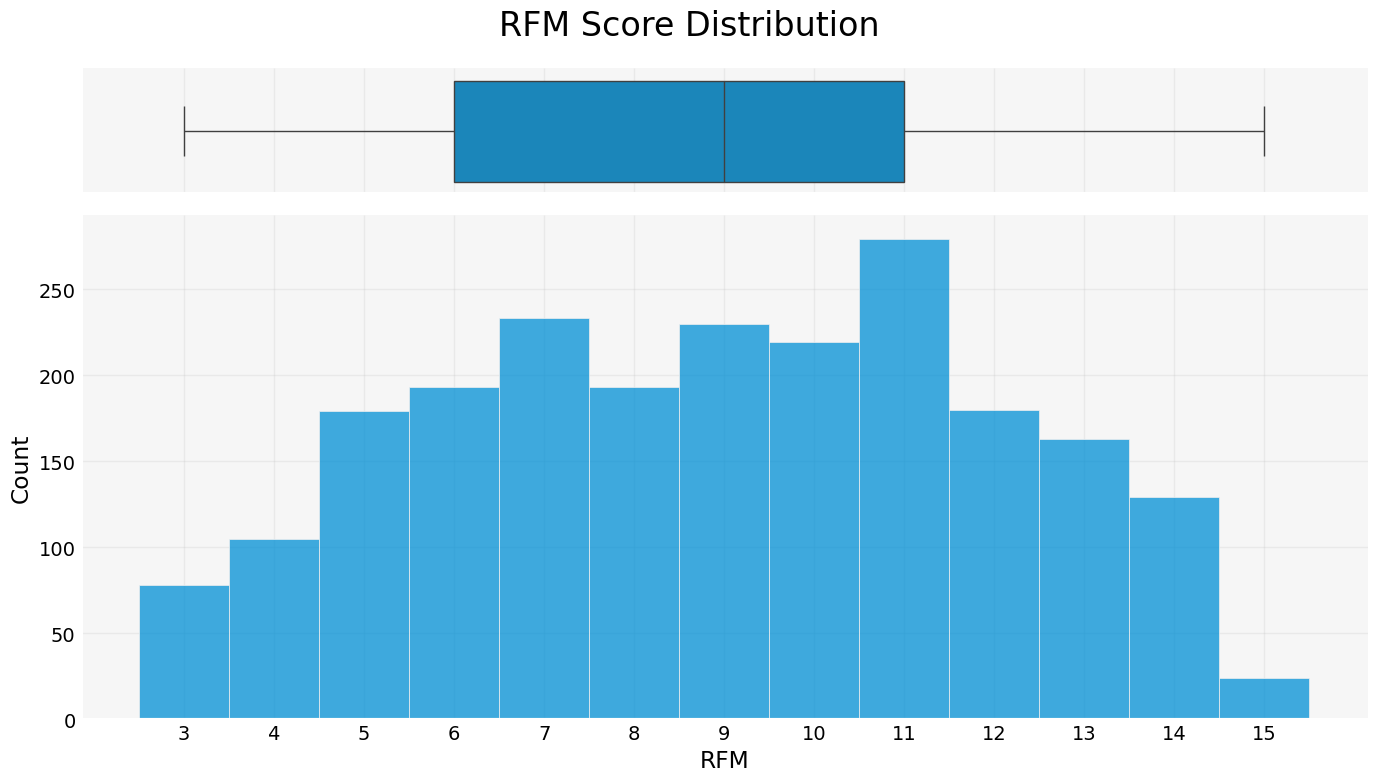

In [8]:
fig, axs = plt.subplots(2, 1, gridspec_kw={"height_ratios": [0.2, 0.8]}, sharex=True)

sns.boxplot(data=df_rfm, x="RFM", ax=axs[0])
sns.histplot(data=df_rfm, x="RFM", discrete=True, ax=axs[1])

axs[1].set_xticks(range(3, 16))

fig.suptitle("RFM Score Distribution")

plt.show()

As can be seen, the box of the boxplot goes from the score 6 to the score 11. Remember that the box of the boxplot encompasses 50% of the data. This means that the majority of the customers are in the Occasional, Engaged, and the lower end of the Valuable segments. The Dormant and Elite segments have fewer customers.

Finally, we can check the distribution of the RFM segments:

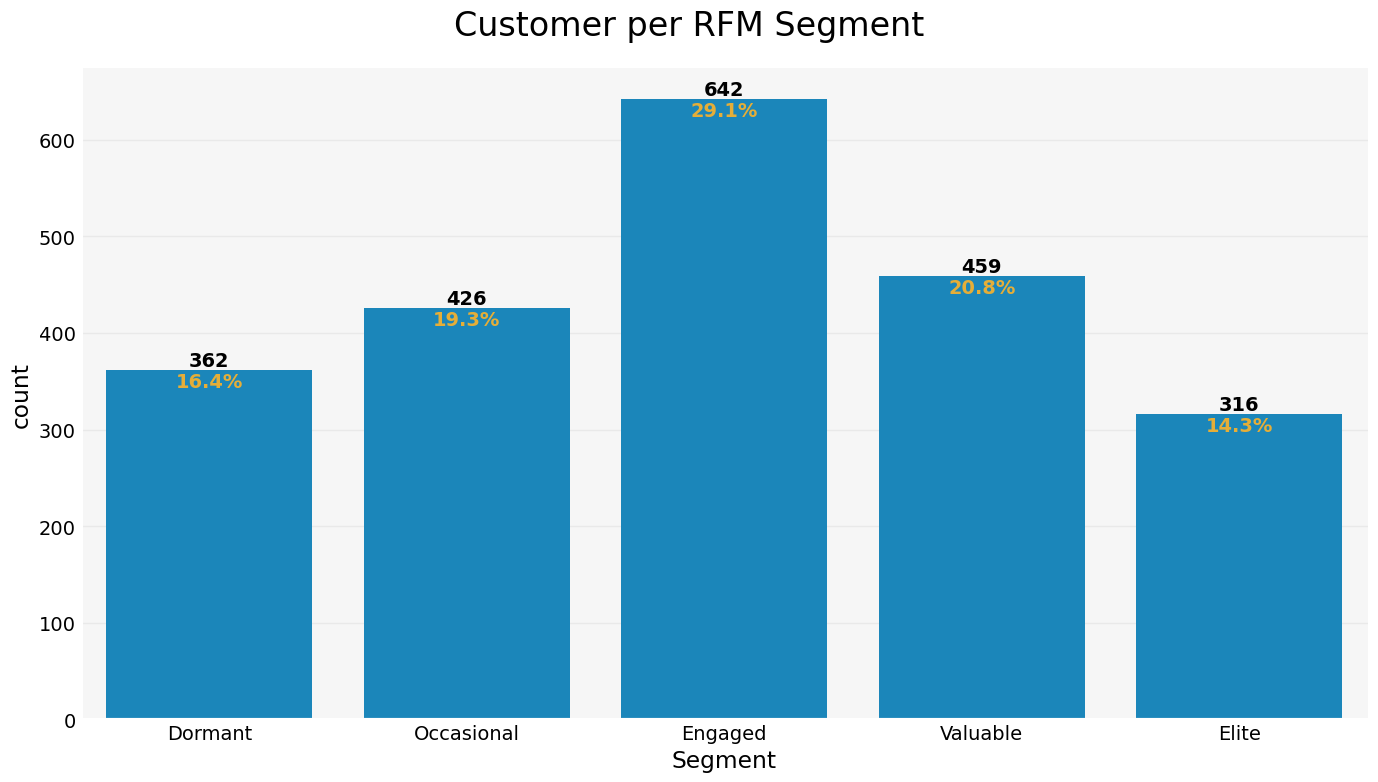

In [9]:
fig, ax = plt.subplots()

c = sns.countplot(data=df_rfm, x="Segment", ax=ax)

# absolute
c.bar_label(c.containers[0], weight="bold")

# percentage
total = df_rfm.shape[0]

for bar in c.containers:
    c.bar_label(
        bar,
        fmt=lambda x: f"{x / total * 100:.1f}%",
        label_type="edge",
        padding=-15,
        color="C2",
        weight="bold",
    )

fig.suptitle("Customer per RFM Segment")

plt.show()

Just for completeness, we can check the distribution of all the columns:

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'Recency'}>,
        <Axes: title={'center': 'Frequency'}>],
       [<Axes: title={'center': 'Monetary'}>,
        <Axes: title={'center': 'R'}>, <Axes: title={'center': 'F'}>],
       [<Axes: title={'center': 'M'}>, <Axes: title={'center': 'RFM'}>,
        <Axes: >]], dtype=object)

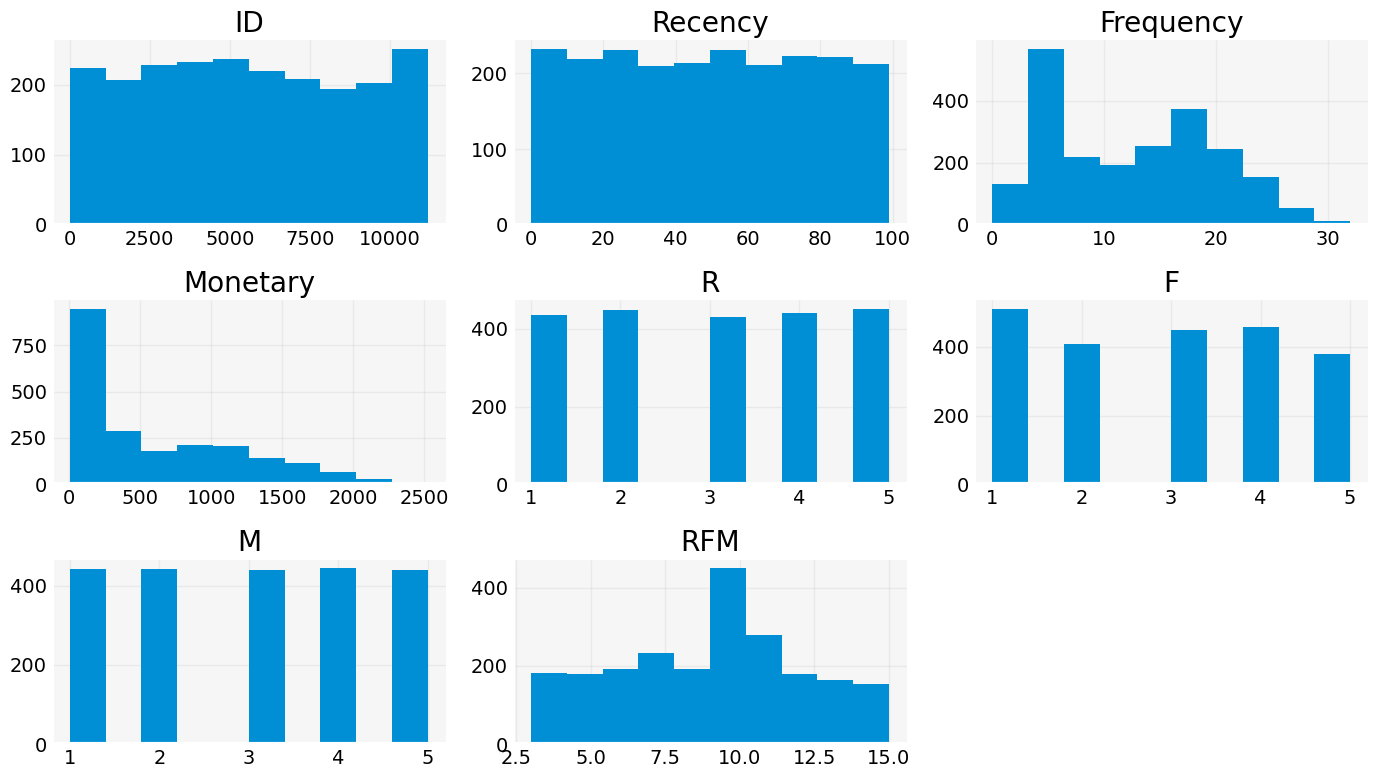

In [10]:
df_rfm.hist()

As also check the range of each segment:

<Axes: xlabel='Segment', ylabel='RFM'>

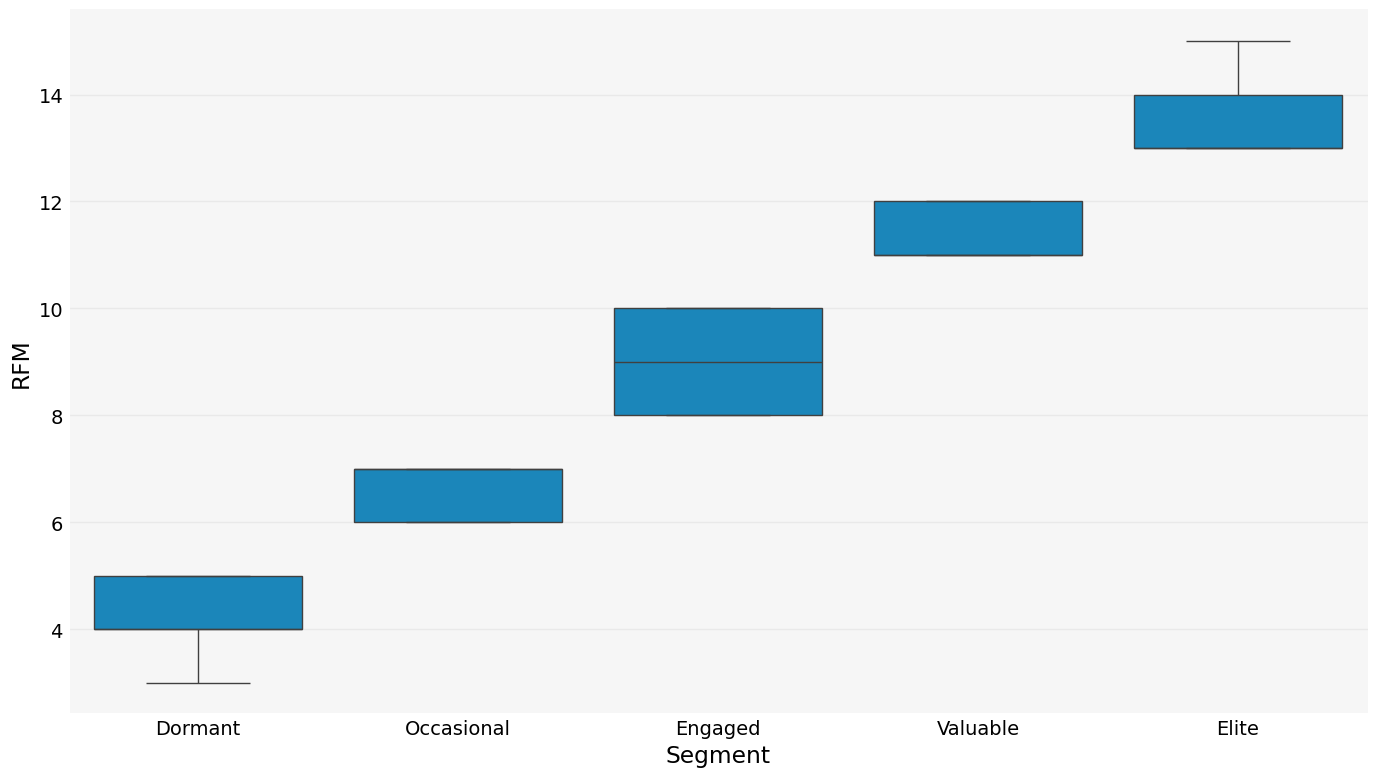

In [11]:
sns.boxplot(data=df_rfm, x="Segment", y="RFM")

## Exploring the segments

The most important information is the distribution of the RFM segments. This information can be used to create targeted marketing strategies for each segment.

We can use boxplots to visualize the distribution of the RFM values for each segment, considering each RFM value separately (Recency, Frequency, and Monetary Value):

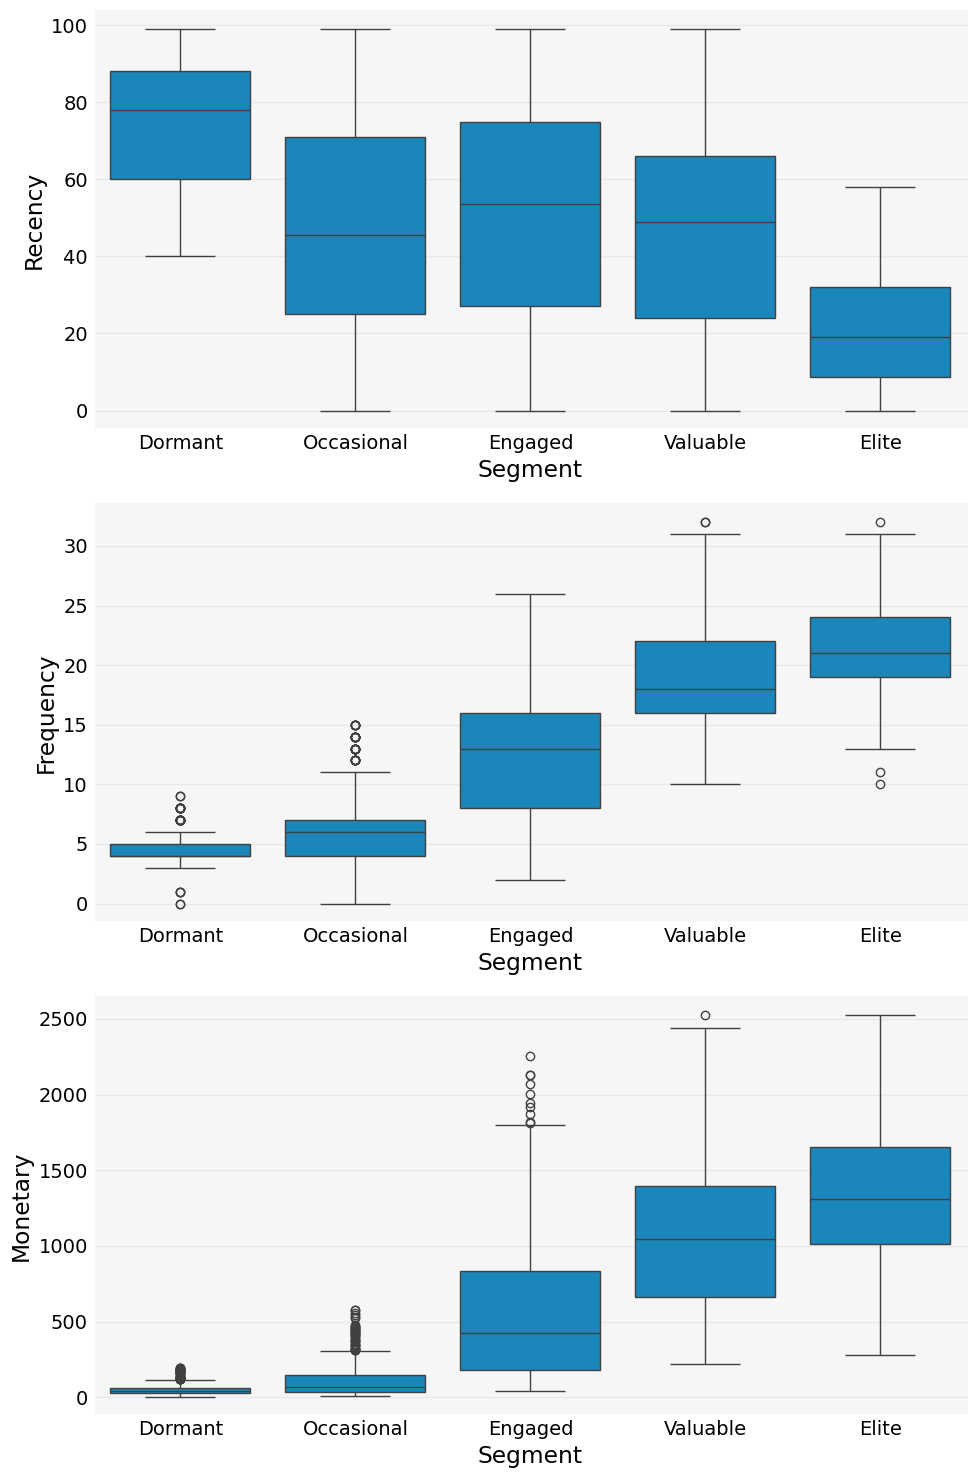

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for ax, column in zip(axs.flat, ["Recency", "Frequency", "Monetary"]):
    sns.boxplot(data=df_rfm, x="Segment", y=column, ax=ax)

plt.show()

We clearly see that *Elite* customers have the highest monetary value, the highest frequency, and the lowest recency. This is expected since they are the most valuable customers. On the other hand, *Dormant* customers have the lowest monetary value, the lowest frequency, and the highest recency. This is also expected since they are the least valuable customers.

We can reinforce this analysis by calculating the median values of each RFM feature for each segment. And, then, we can normalize the values to see the relative importance of each feature for each segment:

In [13]:
median_rfm = df_rfm.groupby("Segment", observed=False).median()[
    ["Recency", "Frequency", "Monetary"]
]

median_rfm

,Recency,Frequency,Monetary
Segment,,,
Dormant,78.0,4.0,44.0
Occasional,45.5,6.0,65.0
Engaged,53.5,13.0,424.0
Valuable,49.0,18.0,1045.0
Elite,19.0,21.0,1311.0


In [ ]:
# normalize values to compare
for column in ["Recency", "Frequency", "Monetary"]:
    median_rfm[column] = (median_rfm[column] - median_rfm[column].min()) / (
        median_rfm[column].max() - median_rfm[column].min()
    )

median_rfm

,Recency,Frequency,Monetary
Segment,,,
Dormant,1.000000,0.000000,0.000000
Occasional,0.449153,0.117647,0.016575
Engaged,0.584746,0.529412,0.299921
Valuable,0.508475,0.823529,0.790055
Elite,0.000000,1.000000,1.000000


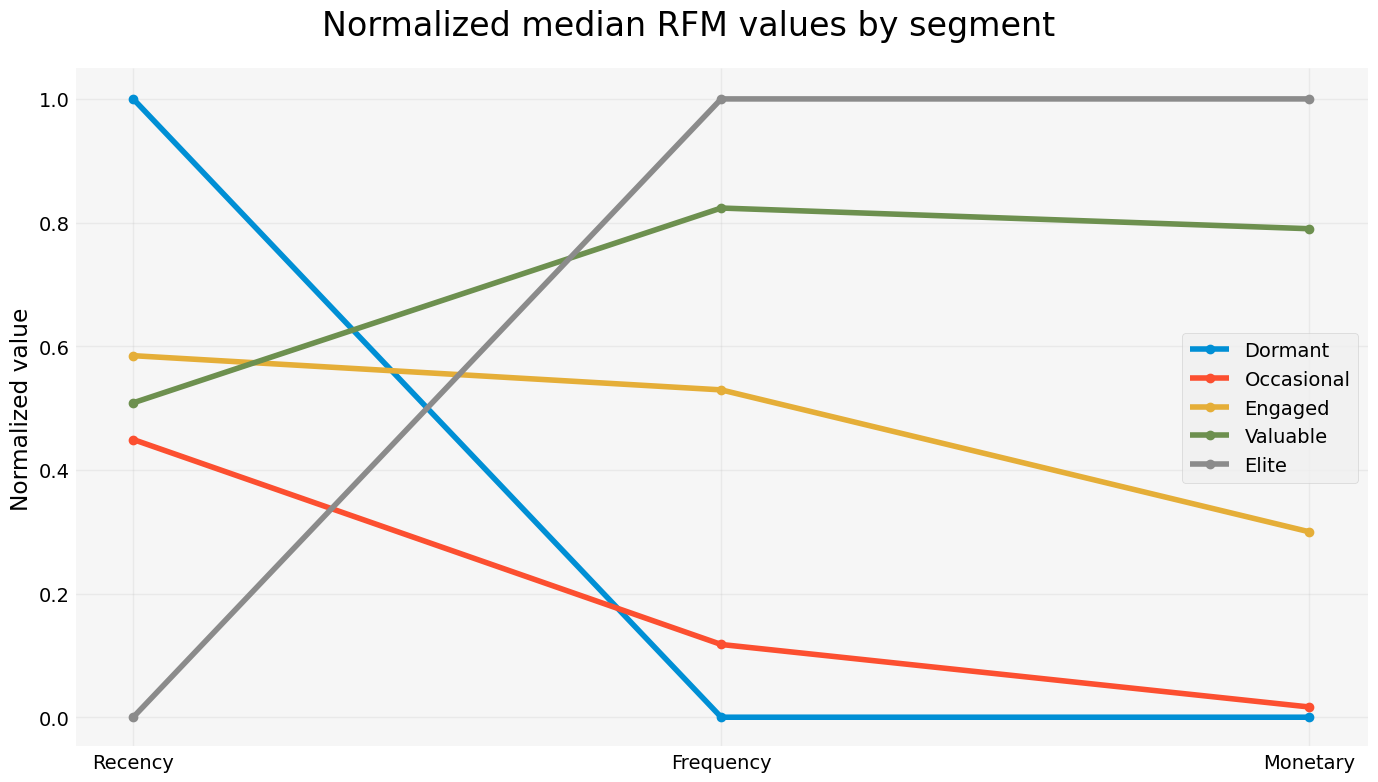

In [15]:
fig, ax = plt.subplots()

ax.plot(median_rfm.T, marker="o")

ax.legend(median_rfm.index)

ax.set_ylabel("Normalized value")

fig.suptitle("Normalized median RFM values by segment")

plt.show()

See that the *Elite* segment has the highest median values for Frequency and Monetary Value, and the lowest median value for Recency. This is consistent with the previous analysis.

The *Valuable* segment has the second-highest median values for Frequency and Monetary Value, and the third median value for Recency. The recency value of this segment needs to be improved to reach the *Elite* segment.

The *Engaged* segment has mid-range median values for Recency and Frequency, but the median for Monetary is closer to the lower end.

The main difference between the *Occasional* and *Dormant* segments is the median value of Recency. The *Occasional* segment has a higher median value for Recency, close to the value of the *Engaged* segment. While the *Dormant* segment has the highest median value for Recency.

Finally, the *Dormant* segment has the lowest median values for Frequency and Monetary Value, and the highest median value for Recency. 

## Defining personas for each segment

For marketing campaigns, it is useful to create a customer profile for each segment. This profile can be used to create targeted marketing strategies for each segment. We can merge the dataframe that we created for the RFM analysis with the original dataframe to get additional information about the customers and create the customer profiles.


In [16]:
df_rfm

,ID,Recency,Frequency,Monetary,R,F,M,RFM,Segment
0,5524,58,22,1617,3,5,5,13,Elite
1,2174,38,4,27,4,1,1,6,Occasional
2,4141,26,20,776,4,4,4,12,Valuable
3,6182,26,6,53,4,2,1,7,Occasional
4,5324,94,14,422,1,3,3,7,Occasional
...,...,...,...,...,...,...,...,...,...
2200,10870,46,16,1341,3,4,5,12,Valuable
2201,4001,56,15,444,3,3,3,9,Engaged
2202,7270,91,18,1241,1,4,5,10,Engaged
2203,8235,8,21,843,5,5,4,14,Elite


In [17]:
# add group column to original dataframe df
df = df.merge(df_rfm[["ID", "Segment"]], on="ID")

df.head()

,ID,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,MonthsSinceEnrolled,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,Segment
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,...,22,46-60,1617,1529,0,0,0,0,22,Elite
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,...,3,46-60,27,21,2,1,0,0,4,Occasional
2,4141,Graduation,Partner,71613.0,26,426,49,127,111,21,...,10,46-60,776,734,0,0,0,0,20,Valuable
3,6182,Graduation,Partner,26646.0,26,11,4,20,10,3,...,4,18-30,53,48,1,1,0,0,6,Occasional
4,5324,PhD,Partner,58293.0,94,173,43,118,46,27,...,5,31-45,422,407,1,1,0,0,14,Occasional


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   2205 non-null   int16   
 1   Education            2205 non-null   category
 2   Marital_Status       2205 non-null   category
 3   Income               2205 non-null   float64 
 4   Recency              2205 non-null   int8    
 5   MntWines             2205 non-null   int16   
 6   MntFruits            2205 non-null   int16   
 7   MntMeatProducts      2205 non-null   int16   
 8   MntFishProducts      2205 non-null   int16   
 9   MntSweetProducts     2205 non-null   int16   
 10  MntGoldProds         2205 non-null   int16   
 11  NumWebPurchases      2205 non-null   int8    
 12  NumCatalogPurchases  2205 non-null   int8    
 13  NumStorePurchases    2205 non-null   int8    
 14  Complain             2205 non-null   category
 15  Response             

Let's check how each segment is distributed in terms of the target variable:

<Axes: xlabel='Segment', ylabel='Count'>

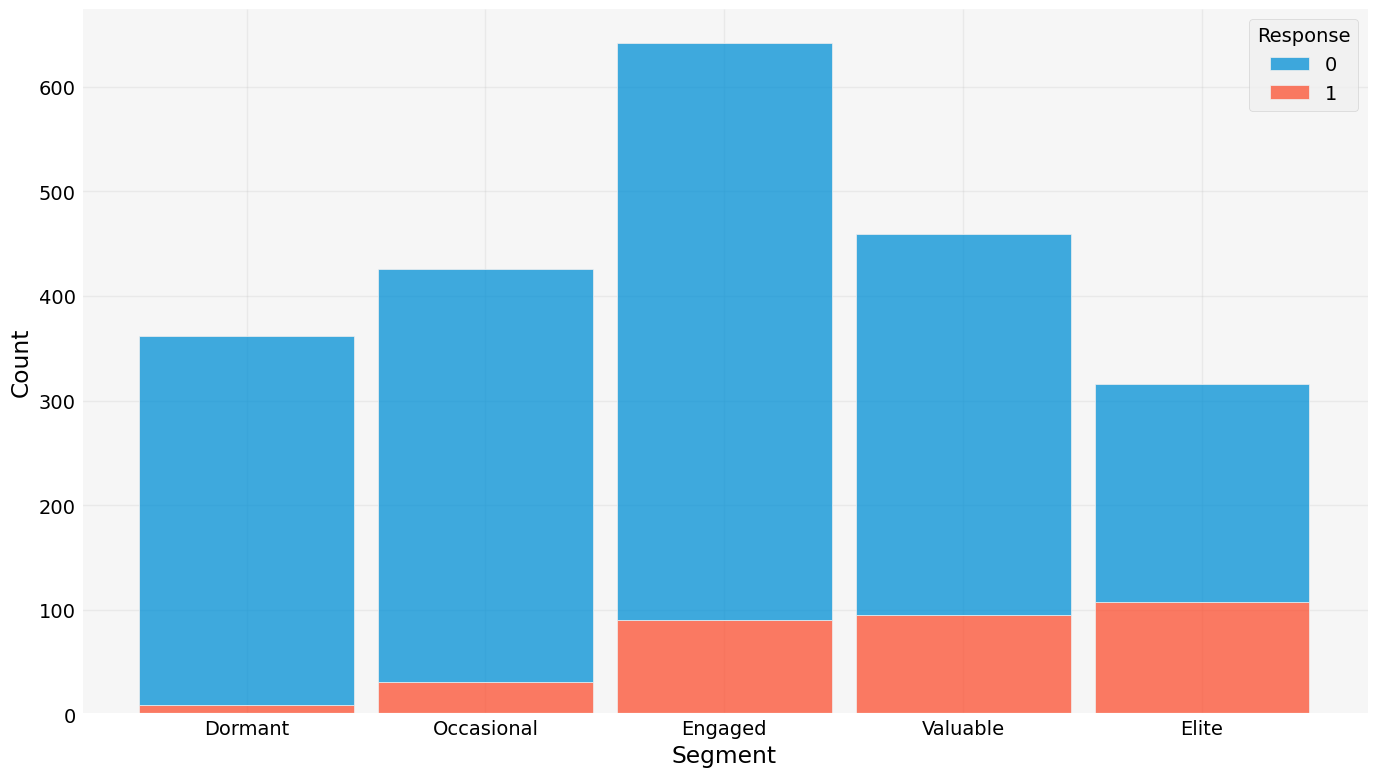

In [19]:
sns.histplot(
    data=df,
    x="Segment",
    hue="Response",
    multiple="stack",
    shrink=0.9,
)

<Axes: xlabel='Segment', ylabel='Percent'>

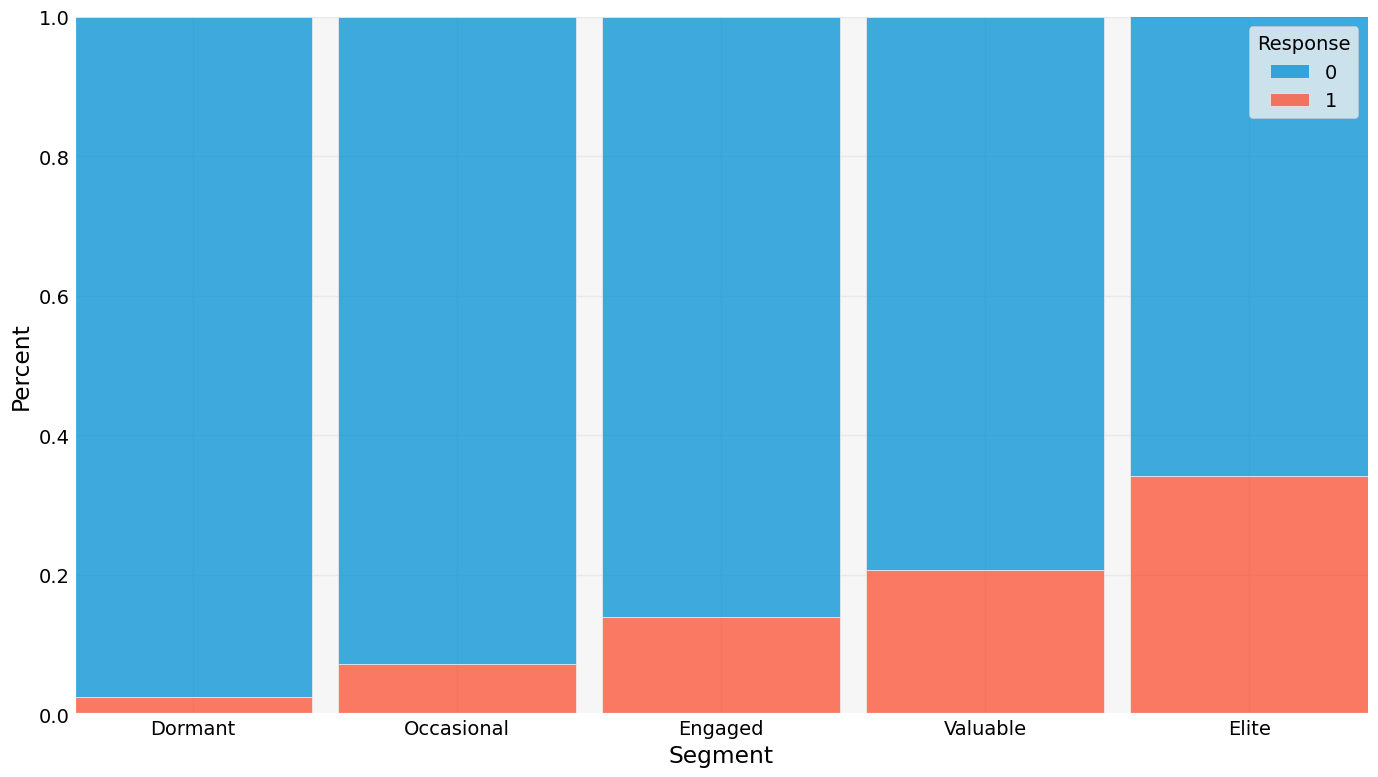

In [20]:
sns.histplot(
    data=df,
    x="Segment",
    hue="Response",
    multiple="fill",
    stat="percent",
    shrink=0.9,
)

We clearly see that the *Elite* segment has the highest percentage of customers that converted in the pilot campaign. This is expected since they are the most valuable customers. On the other hand, the *Dormant* segment has the lowest percentage of customers that converted in the pilot campaign. This is also expected since they are the least valuable customers.

We can expand this analysis to other categorical variables in the dataset:

In [21]:
columns_segment_analysis = [
    "HasChildren",
    "Marital_Status",
    "Education",
    "HasAcceptedCmp",
    "AgeGroup",
    "Response",
]

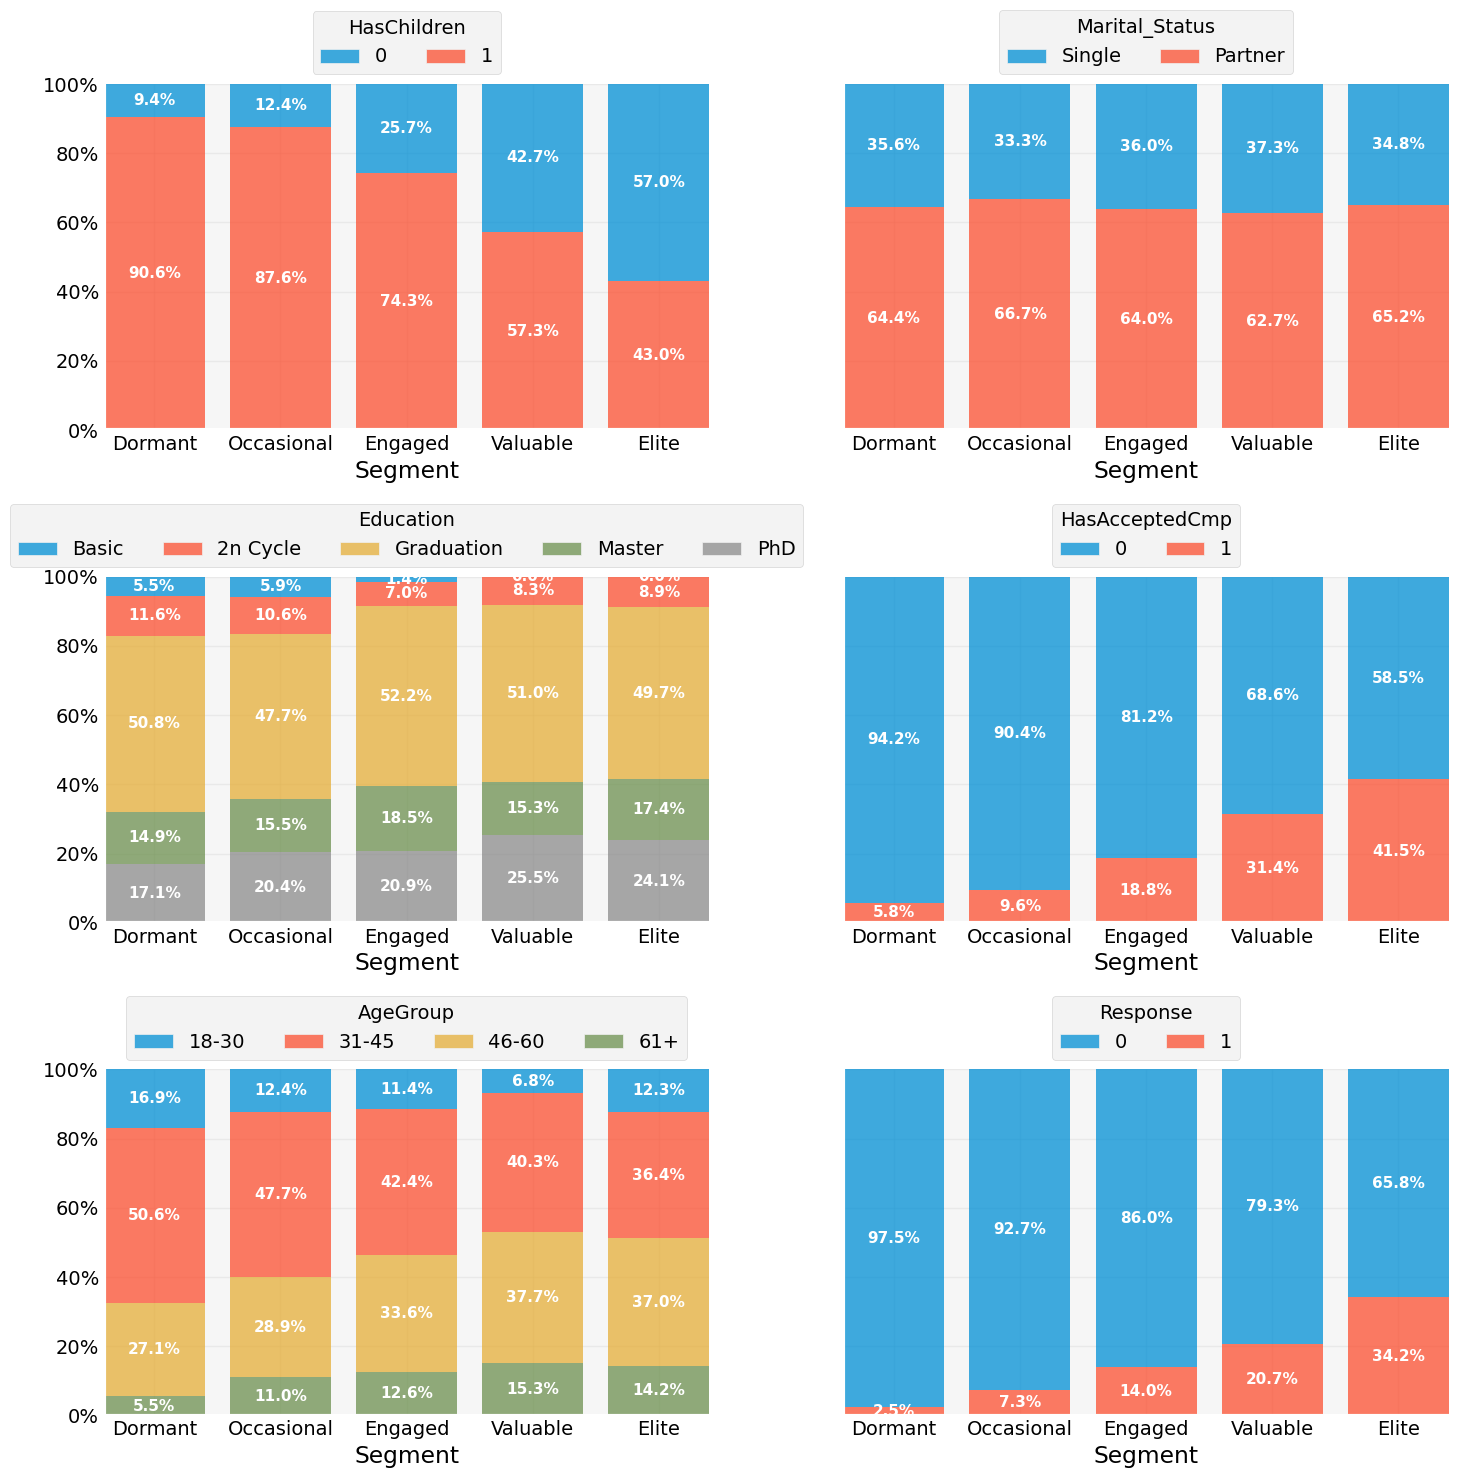

In [22]:
plot_category_distribution_by_cluster(
    df,
    columns_segment_analysis,
    column_cluster="Segment",
    rows_cols=(3, 2),
    figsize=(15, 15),
)

It is clear that the higher the RFM score the lower the tendency to have children. Also, the most valuable segments have older customers (higher percentages for 46-60 and 61+ age groups) and higher percentages of customers with higher education levels (graduation or higher).

The marital status is more evenly distributed among the segments, with no clear pattern.

In the previous chart, we used the segment as x-axis and some categorical variable as the hue. We can also use the segment as the hue and some categorical variable as the x-axis:

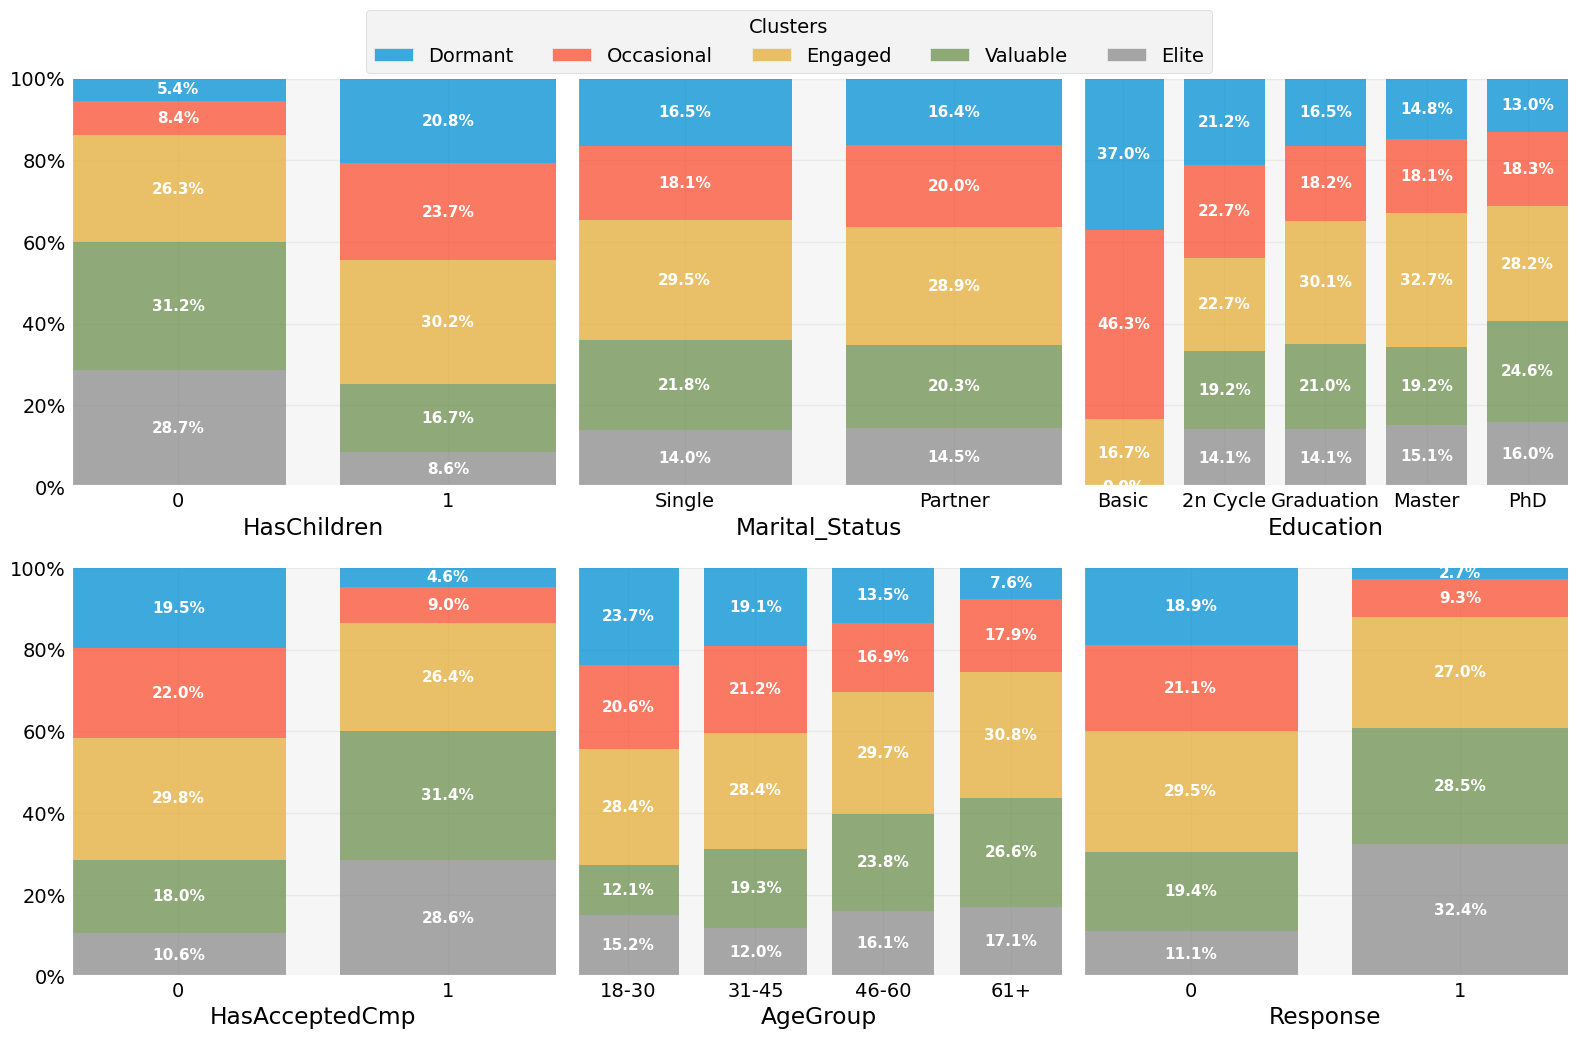

In [23]:
plot_cluster_distribution_by_category(
    df, columns_segment_analysis, column_cluster="Segment", figsize=(16, 10)
)

The findings are consistent with the previous analysis. There is a clear pattern in the distribution of the segments for the number of children, age group, and education level. The marital status is more evenly distributed among the segments.


We can also use the segment as the hue and some numerical variable as the x-axis:

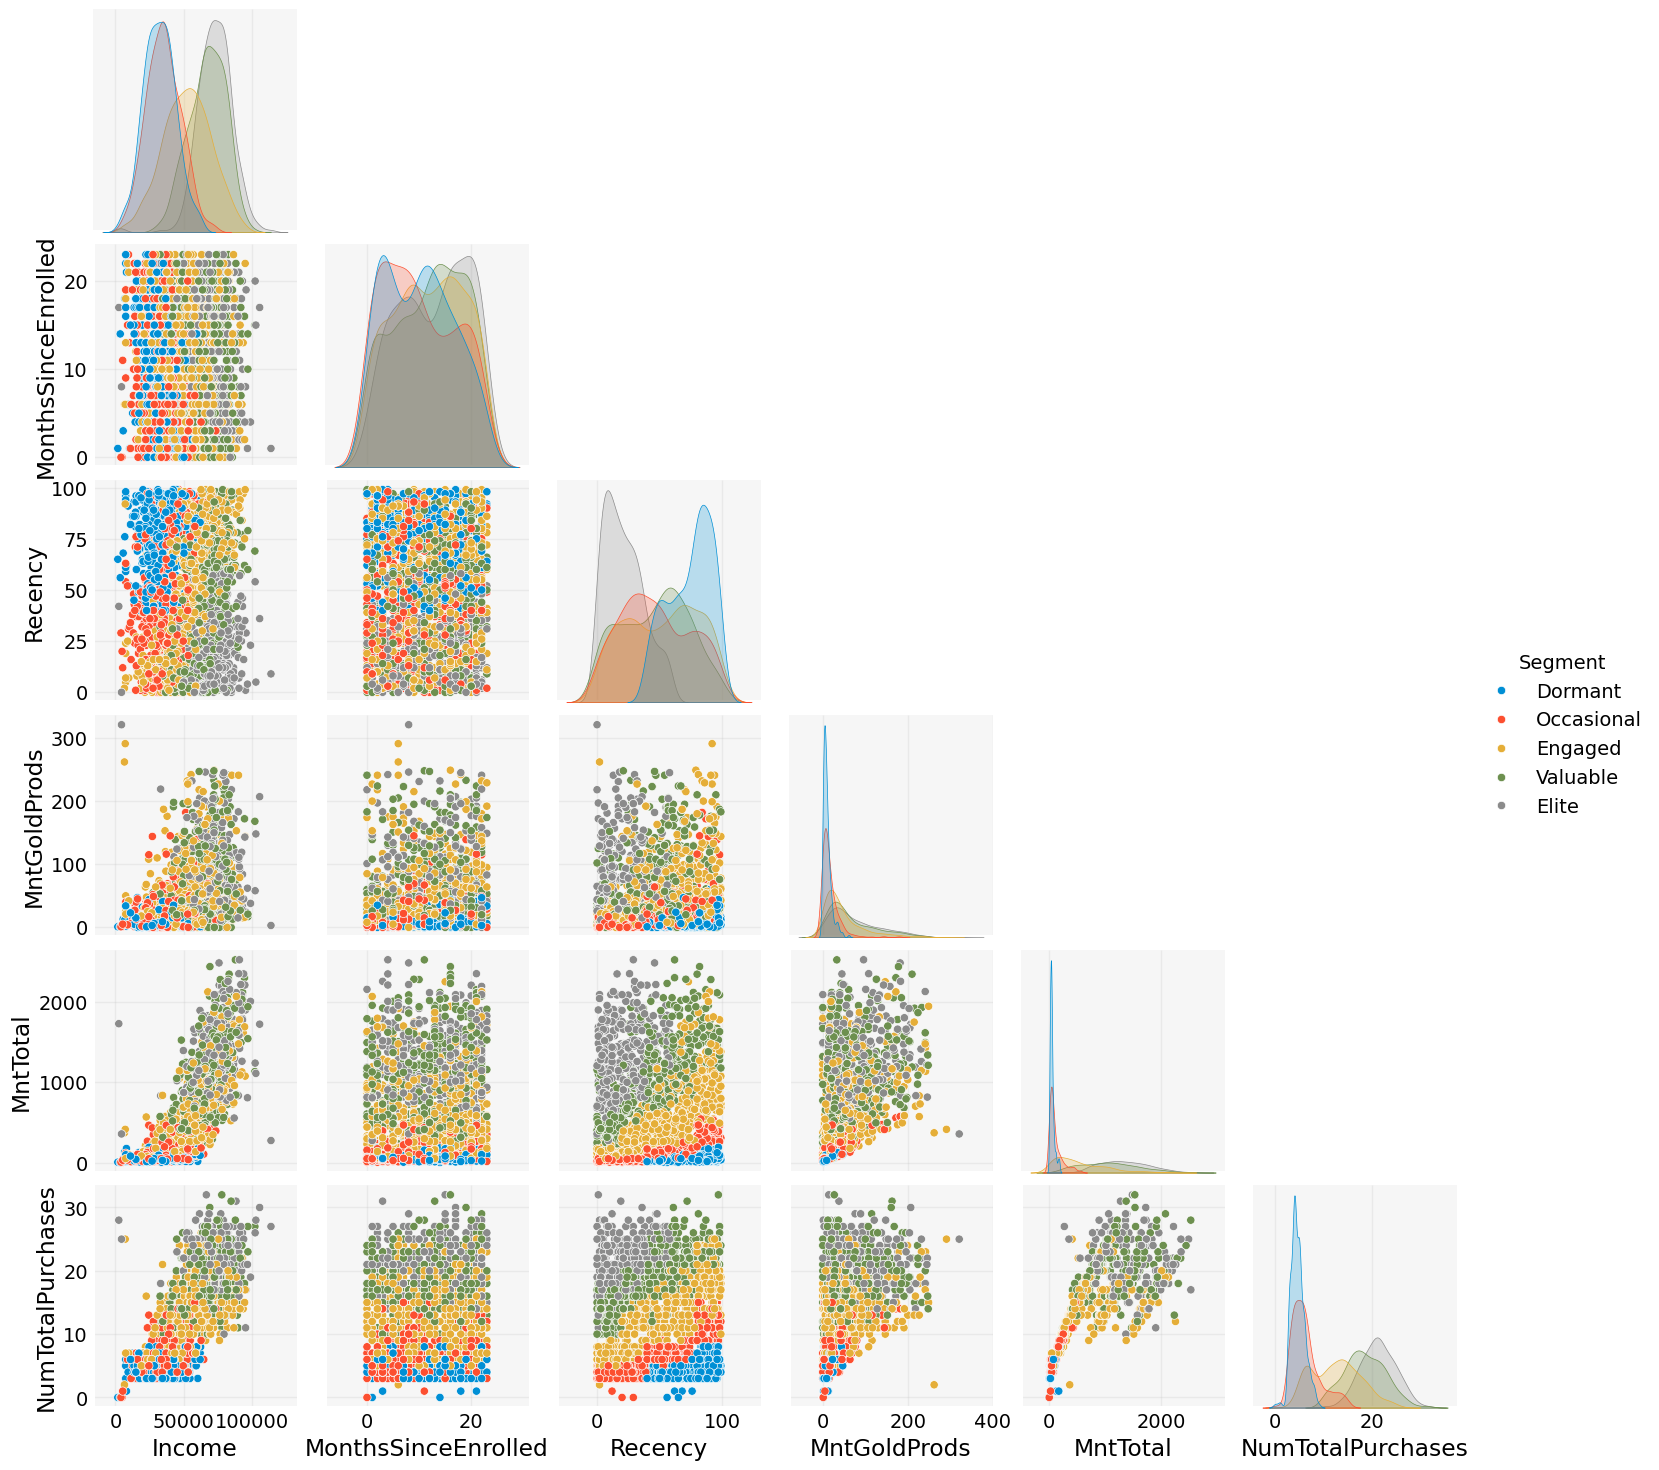

In [24]:
sns.pairplot(
    data=df,
    vars=[
        "Income",
        "MonthsSinceEnrolled",
        "Recency",
        "MntGoldProds",
        "MntTotal",
        "NumTotalPurchases",
    ],
    hue="Segment",
    corner=True,
    diag_kind="kde",
    diag_kws={"common_norm": False},
)

As expected, the *Elite* segment has the highest average income, while the *Dormant* segment has the lowest average income. The other segments have intermediate average income values.

The recency, frequency, and monetary value are consistent with the previous analysis. 


We can now describe our personas or customer profiles for each segment:

- **Dormant**
  - **Description:** These customers have the lowest engagement. They haven't purchased recently, buy infrequently, and spend little.
  - **Marketing Strategy:** Reactivation campaigns such as discounts or personalized offers may help re-engage them.
  - **Customer Profile:**
    - **Demographics:** Customers with children, younger age group, lower education level, and lower income.
    - **Behavior:** Low recency, low frequency, low monetary value.
    - **Tendency to convert:** Lowest.

- **Occasional**
  - **Description:** Customers in this group make occasional purchases but are not highly engaged. They may have made a few transactions but do not shop consistently.
  - **Marketing Strategy:** Encourage more frequent purchases through targeted promotions or loyalty incentives.
  - **Customer Profile:**
    - **Demographics:** Customers with children, younger age group, lower education level, and lower income.
    - **Behavior:** Mid-range recency, low frequency, low monetary value.
    - **Tendency to convert:** Mid to low.

- **Engaged**
  - **Description:** These customers have moderate engagement. They purchase somewhat frequently, and their spending is stable.
  - **Marketing Strategy:** Strengthen the relationship by providing personalized recommendations and exclusive offers.
  - **Customer Profile:**
    - **Demographics:** Customers with children, mid-age group, at least graduation as education level, and mid-range income.
    - **Behavior:** Mid-range recency, mid-range frequency, low monetary value.
    - **Tendency to convert:** Mid-range.

- **Valuable**
  - **Description:** These are high-value customers who purchase often and spend significantly. They have shown consistent engagement.
  - **Marketing Strategy:** Maintain their loyalty through rewards programs, premium offers, and early access to promotions.
  - **Customer Profile:**
    - **Demographics:** Customers may have children or not, older age group, higher education level, and higher income.
    - **Behavior:** Mid-range recency, high frequency, high monetary value.
    - **Tendency to convert:** High.

- **Elite**
  - **Description:** The most valuable customers. They buy frequently, spend a lot, and have remained engaged over time.
  - **Marketing Strategy:** Focus on VIP treatment, premium experiences, and strong retention strategies to ensure long-term loyalty.
  - **Customer Profile:**
    - **Demographics:** Customers probably without children, older age group, higher education level, and higher income.
    - **Behavior:** Low recency, high frequency, high monetary value.
    - **Tendency to convert:** Highest.

## Exporting the data


Finally, we can export our data to the next phase of the analysis, our predictive modeling. Considering that now we have the RFM segments, we can use them as a feature in our predictive model. And we can drop the columns that we used to calculate the RFM score because they are highly correlated with the RFM segments.

In [25]:
columns_to_drop = ["ID", "Recency", "NumTotalPurchases", "MntTotal"]

df = df.drop(columns=columns_to_drop)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2205 non-null   category
 1   Marital_Status       2205 non-null   category
 2   Income               2205 non-null   float64 
 3   MntWines             2205 non-null   int16   
 4   MntFruits            2205 non-null   int16   
 5   MntMeatProducts      2205 non-null   int16   
 6   MntFishProducts      2205 non-null   int16   
 7   MntSweetProducts     2205 non-null   int16   
 8   MntGoldProds         2205 non-null   int16   
 9   NumWebPurchases      2205 non-null   int8    
 10  NumCatalogPurchases  2205 non-null   int8    
 11  NumStorePurchases    2205 non-null   int8    
 12  Complain             2205 non-null   category
 13  Response             2205 non-null   category
 14  MonthsSinceEnrolled  2205 non-null   int8    
 15  AgeGroup             

In [26]:
df.to_parquet(PROCESSED_DATA_FILE_RFM, index=False, engine="fastparquet")

Refs:

https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

https://www.peelinsights.com/post/what-is-rfm-analysis